In [2]:

import glob
import os
import random
import json
import pickle
import pandas as pd
import sqlite3
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import rubin_sim.maf.db as db
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles
from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
#from rubin_sim.utils import galactic_from_equatorial, _healbin, healbin
from rubin_sim.utils import getPackageDir
from rubin_sim.maf.metrics import tgaps
from TgapsPercentMetric import TgapsPercentMetric
import healpy as hp
import rubin_sim.maf.metricBundles as metricBundles


In [3]:
 def make_hist(metricValue, slicer, userPlotDict):
        """
        ripped from https://github.com/lsst/sims_maf/blob/master/python/lsst/sims/maf/plots/specialPlotters.py
        
        Parameters
        ----------
        metricValue : numpy.ma.MaskedArray
            Handles 'object' datatypes for the masked array.
        slicer : lsst.sims.maf.slicers
            Any MAF slicer.
        userPlotDict: dict
            Dictionary of plot parameters set by user (overrides default values).
            'metricReduce' (an lsst.sims.maf.metric) indicates how to marginalize the metric values
            calculated at each point to a single series of values over the sky.
            'histStyle' (True/False) indicates whether to plot the results as a step histogram (True)
            or as a series of values (False)
            'bins' (np.ndarray) sets the x values for the resulting plot and should generally match
            the bins used with the metric.
        fignum : int
            Matplotlib figure number to use (default = None, starts new figure).
        Returns
        -------
        int
           Matplotlib figure number used to create the plot.
        """
        plotDict = {'metricReduce': metrics.SumMetric(), 'histStyle': False}
        plotDict.update(userPlotDict)
        # Combine the metric values across all slicePoints.
        if not isinstance(plotDict['metricReduce'], metrics.BaseMetric):
            raise ValueError('Expected plotDict[metricReduce] to be a MAF metric object.')
        # Get the data type
        dt = metricValue.compressed()[0].dtype
        # Change an array of arrays (dtype=object) to a 2-d array of correct dtype
        mV = np.array(metricValue.compressed().tolist(), dtype=[('metricValue', dt)])
        # Make an array to hold the combined result
        finalHist = np.zeros(mV.shape[1], dtype=float)
        metric = plotDict['metricReduce']
        metric.colname = 'metricValue'
        # Loop over each bin and use the selected metric to combine the results
        for i in np.arange(finalHist.size):
            finalHist[i] = metric.run(mV[:, i])
        bins = plotDict['bins']
        if plotDict['histStyle']:
            leftedge = bins[:-1]
            rightedge = bins[1:]

            x = np.vstack([leftedge, rightedge]).T.flatten()
            y = np.vstack([finalHist, finalHist]).T.flatten()

        else:
            # Could use this to plot things like FFT
            x = bins[:-1]
            y = finalHist
            
        return x, y

In [4]:
import glob

families = ["baseline", "retro", "rolling", "noroll", "presto", "good_seeing", "long_u", "bluer"]
fbss = ["fbs_2.0", "fbs_2.1","fbs_3.0","v3.3_v3.4"]

files = []
for family in families:
    family_files = []  # List of files for this family
    for fbs in fbss:
        family_files += glob.glob(f'../shared/__DEPRECATED__/rubin_opsims/{fbs}/{family}/*10yrs.db')
        family_files += glob.glob(f'../shared/rubin_opsims_{fbs}/{family}/*10yrs.db')
    files.append((family, family_files))

# Display the counts and file names for each family and fbss combination
for family, file_list in files:
    print(f"Family {family}: {len(file_list)} files found")
    for file_name in file_list:
        print(file_name)

# families = ["baseline", "retro", "rolling", "noroll", "presto", "long_gaps", "good_seeing", "long_u"]
# fbss = ['*v1.7_10yrs.db', '*v2.0_10yrs.db', '*v2.1_10yrs.db', '*v3.0_10yrs.db']

# files = []
# for family in families:
#     family_files = []  # List of files for this family
#     for fbs in fbss:
#         family_files += glob.glob(f'../shared/rubin_opsims_v2.0/{family}{fbs}') + glob.glob(f'../shared/rubin_opsims_v2.1/{family}{fbs}')
#     files.append((family, family_files))

# # Display the counts and file names for each family and fbss combination
# for family, file_list in files:
#     print(f"Family {family}: {len(file_list)} files found")
#     for file_name in file_list:
#         print(file_name)

# files += glob.glob(f'../shared/rubin_sim_data-v1.0.3/sim_baseline/baseline_v3.0_10yrs.db')



Family baseline: 6 files found
../shared/__DEPRECATED__/rubin_opsims/fbs_2.0/baseline/baseline_v2.0_10yrs.db
../shared/__DEPRECATED__/rubin_opsims/fbs_2.1/baseline/baseline_v2.1_10yrs.db
../shared/__DEPRECATED__/rubin_opsims/fbs_3.0/baseline/baseline_v3.0_10yrs.db
../shared/rubin_opsims_v3.3_v3.4/baseline/baseline_v3.4_10yrs.db
../shared/rubin_opsims_v3.3_v3.4/baseline/baseline_v3.3_10yrs.db
../shared/rubin_opsims_v3.3_v3.4/baseline/baseline_v3.2_10yrs.db
Family retro: 2 files found
../shared/__DEPRECATED__/rubin_opsims/fbs_2.0/retro/baseline_retrofoot_v2.0_10yrs.db
../shared/__DEPRECATED__/rubin_opsims/fbs_2.0/retro/retro_baseline_v2.0_10yrs.db
Family rolling: 4 files found
../shared/__DEPRECATED__/rubin_opsims/fbs_2.0/rolling/rolling_ns2_rw0.5_v2.0_10yrs.db
../shared/__DEPRECATED__/rubin_opsims/fbs_2.0/rolling/rolling_ns2_rw0.9_v2.0_10yrs.db
../shared/__DEPRECATED__/rubin_opsims/fbs_2.0/rolling/rolling_ns3_rw0.5_v2.0_10yrs.db
../shared/__DEPRECATED__/rubin_opsims/fbs_2.0/rolling/roll

In [6]:
summary_fam = defaultdict(dict)
#for family, fbs in zip(families[:1], fbss[:1]):
for family in families:
    for fbs in fbss:
    # Let's use glob to make a list of database files. Replace the path with wherever you have your dbs stored
        if fbs == "fbs_2.1":
            files = glob.glob(f'../shared/__DEPRECATED__/rubin_opsims/fbs_2.1/{family}/*_10yrs.db')
        else: 
            files = glob.glob(f'../shared/__DEPRECATED__/rubin_opsims/{fbs}/{family}/*10yrs.db')
            files += glob.glob(f'../shared/rubin_opsims_{fbs}/{family}/*10yrs.db')
            files.sort()

    # Name of the runs
        run_names = [filename.split('/')[-1].replace('.db', '').replace('.db', '') for filename in files]
    #run_names = [filename.split('/')[-1].replace('_v1.510yrs.db', '').replace('_v1.5_10yrs.db', '') for filename in files]
   
    # Initialize the list of results
        results = []

    # Loop over each file, save the results in a list
        for filename, run_name in zip(files, run_names):
            opsdb = db.OpsimDatabase(filename)
    # Set each run to save results in a new directory
            outDir = 'fbs_3.4_plot'
            resultsDb = db.ResultsDb(outDir=outDir)

            bundleList = []
            sql = ''
            metric =  metrics.TgapsMetric(bins=np.logspace(-3.46,3.54,99),allGaps=False)
            slicer = slicers.HealpixSlicer(nside=64)
            summaryMetrics=[metrics.MedianMetric()]
            plotDict = {'bins':np.logspace(-3.46,3.54,99)}
            plotFuncs = [plots.SummaryHistogram()]
              
            bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=run_name, plotDict=plotDict, plotFuncs=plotFuncs)
        
            bd = metricBundles.makeBundlesDictFromList([bundle])
            bg = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
            bg.runAll()
        # Plotting
        # bg.plotAll(closefigs=False)

        # NOTE: this was changed from Peter's tutorial, because results.append(bundleList) returned empty summaries
        #results.append(bundleList)
        
        # Dictionary of metric results
            metric_names = bd.keys()
            summary_fam[family][run_name] = defaultdict(dict)
        
            print(metric_names)
            for metric_name in metric_names:
                if 'Tgaps_' in metric_name:
                    try:
                        x, y = make_hist(bd[metric_name].metricValues, slicer,{'bins':np.logspace(-3.46,3.54,99)})
                    except KeyError:
                        continue
                # Update the summary_fam dictionary
                    summary_fam[family][run_name][metric_name] = {}
                    summary_fam[family][run_name][metric_name]["dt_hist_x"] = x
                    summary_fam[family][run_name][metric_name]["dt_hist_y"] = y
                else:
                    summary_fam[family][run_name][metric_name] = bd[metric_name].summaryValues
        

        

        
# Save the results in a pkl file
#with open('histograms_1.7.pickle', 'wb') as handle:
with open('fbs_3.4_plot_histograms_2024.pickle', 'wb') as handle:
#with open('histograms_1.5.pickle', 'wb') as handle:
    pickle.dump(summary_fam, handle, protocol=pickle.HIGHEST_PROTOCOL) 
########################
# # # Adjusted file paths and cadences
# # families = ["baseline_v2.0_10yrs", "baseline_v2.1_10yrs", "baseline_v3.0_10yrs"]
# # folders = ["rubin_opsims_v2.1", "rubin_opsims_v2.0", "rubin_opsims_v3.0"]
# # fbss = ['*v2.0_10yrs.db', '*v2.1_10yrs.db', '*v3.0_10yrs.db']

# summary_fam = defaultdict(dict)



# families = ["baseline_v2.0_10yrs", "baseline_v2.1_10yrs", "baseline_v3.0_10yrs"]
# folders = ["rubin_opsims_v2.1", "rubin_opsims_v2.0", "rubin_opsims_v3.0"]
# fbss = ["fbs_2.1", "fbs_2.0", "fbs_3.0"]  # Assuming this is the list of fbs versions

# for family in families:
#     for fbs in fbss:
#         if fbs == "fbs_2.1":
#             if not family == "baseline":
#                 continue
#             files = glob.glob("/sims_maf/fbs_2.1/baseline/*_10yrs.db")
#         else:
#             files = glob.glob(f'/sims_maf/{fbs}/{family}/*_10yrs.db')
#             files.sort()

#         print(f"Family: {family}, FBS: {fbs}")
       

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
dict_keys(['baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL'])
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
dict_keys(['baseline_v2_1_10yrs_Tgaps_observationStartMJD_HEAL'])
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
dict_keys(['baseline_v3_0_10yrs_Tgaps_observationStartMJD_HEAL'])
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
dict_keys(['baseline_v3_2_10yrs_Tgaps_observationStartMJD_HEAL'])
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
dict_keys(['baseline_v3_3_10yrs_Tgaps_observationStartMJD_HEAL'])
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
dict_keys(['baseline_v3_4_10yrs_Tgaps_observationStartMJD_HEAL'])
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
dict_keys(['baseline_retrofoot_v2_0_10yrs_Tgaps_observationStartMJD_HEAL'])
Hea

In [5]:
b = {}
for fname in ['fbs_3.4_plot_histograms_2024.pickle']:
    with open(fname, 'rb') as handle:
        d = pickle.load(handle)
        for key in d.keys():
            b[key] = d[key]

In [6]:
b

{'baseline': {'baseline_v2.0_10yrs': defaultdict(dict,
              {'baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL': {'dt_hist_x': array([3.46736850e-04, 4.08722524e-04, 4.81789291e-04, 5.67918105e-04,
                       6.69444050e-04, 7.89119649e-04, 9.30189491e-04, 1.09647820e-03,
                       1.29249411e-03, 1.52355151e-03, 1.79591474e-03, 2.11696796e-03,
                       2.49541544e-03, 2.94151745e-03, 3.46736850e-03, 4.08722524e-03,
                       4.81789291e-03, 5.67918105e-03, 6.69444050e-03, 7.89119649e-03,
                       9.30189491e-03, 1.09647820e-02, 1.29249411e-02, 1.52355151e-02,
                       1.79591474e-02, 2.11696796e-02, 2.49541544e-02, 2.94151745e-02,
                       3.46736850e-02, 4.08722524e-02, 4.81789291e-02, 5.67918105e-02,
                       6.69444050e-02, 7.89119649e-02, 9.30189491e-02, 1.09647820e-01,
                       1.29249411e-01, 1.52355151e-01, 1.79591474e-01, 2.11696796e-01,
        

In [17]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

# your attempt:

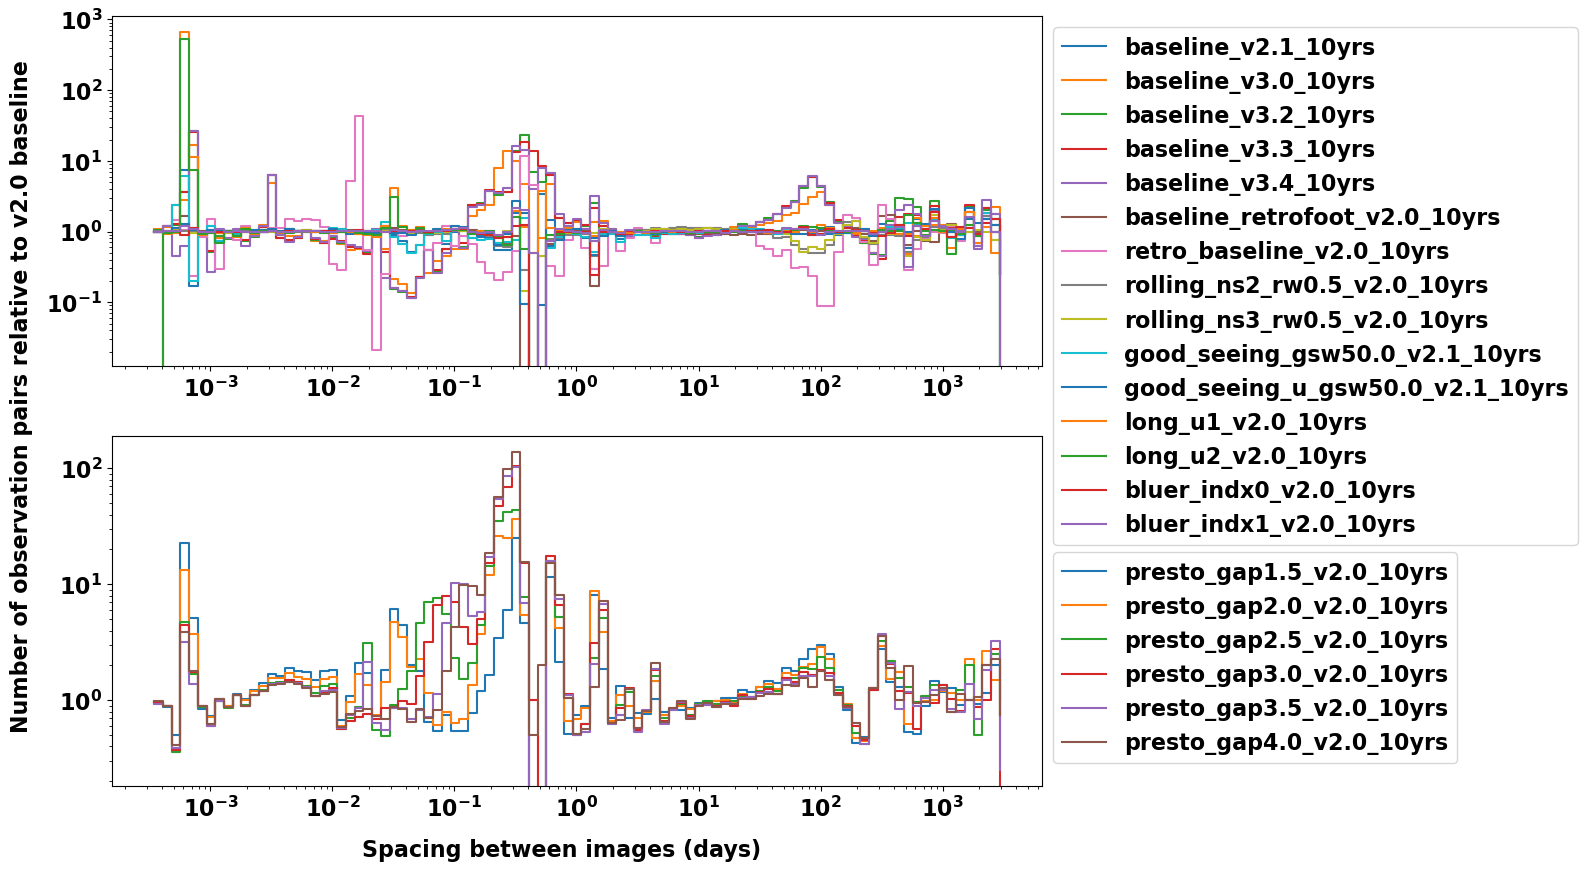

In [12]:
import matplotlib.pyplot as plt

# Part C
import matplotlib
font = {'family': 'sans-serif',
        'weight': 'bold',
        'size': 16}
matplotlib.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10))
fig.text(0.5, 0.04, 'Spacing between images (days)', ha='center')
fig.text(0.04, 0.5, 'Number of observation pairs relative to v2.0 baseline', va='center', rotation='vertical')

cadences_to_plot = [
    "baseline_v2.0_10yrs",
    "baseline_v2.1_10yrs",
    "baseline_v3.0_10yrs",
    "baseline_v3.2_10yrs",
    "baseline_v3.3_10yrs",
    "baseline_v3.4_10yrs",
    "baseline_retrofoot_v2.0_10yrs",
    "retro_baseline_v2.0_10yrs",
    "rolling_ns2_rw0.5_v2.0_10yrs",
    #"rolling_ns2_rw0.9_v2.0_10yrs",
    "rolling_ns3_rw0.5_v2.0_10yrs",
    #"rolling_ns3_rw0.9_v2.0_10yrs",
    "noroll_v2.0_10yrs.db",
    #"good_seeing_gsw0.0_v2.1_10yrs",
    "good_seeing_gsw50.0_v2.1_10yrs",
    #"good_seeing_u_gsw0.0_v2.1_10yrs",
    "good_seeing_u_gsw50.0_v2.1_10yrs",
    "long_u2_v2.0_10yrs",
    "long_u1_v2.0_10yrs",
    "bluer_indx0_v2.0_10yrs",
    "bluer_indx1_v2.0_10yrs"
]


# Plotting for ax1
for family in ["baseline", "retro", "rolling", "noroll", "good_seeing", "long_u", "bluer"]:
    for run in b[family].keys():
        if run in cadences_to_plot:
            if run == "baseline_v2.0_10yrs":
                continue
            metric = list(b[family][run].keys())[0]
            x = b[family][run][metric]['dt_hist_x']
            y = b[family][run][metric]['dt_hist_y'] / b["baseline"]["baseline_v2.0_10yrs"][
                "baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
            ax1.semilogy(x, y, ds='steps-post', label=run)

ax1.set_xscale('log')
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

# Plotting for ax2
for family in ['presto']:
    for run in b[family].keys():
        if run.startswith("presto_gap") and run not in ["presto_gap1.5_mix_v2.0_10yrs",
                                                        "presto_gap2.0_mix_v2.0_10yrs",
                                                        "presto_gap2.5_mix_v2.0_10yrs",
                                                        "presto_gap3.0_mix_v2.0_10yrs",
                                                        "presto_gap3.5_mix_v2.0_10yrs",
                                                        "presto_gap4.0_mix_v2.0_10yrs"]:
            metric = list(b[family][run].keys())[0]
            x = b[family][run][metric]['dt_hist_x']
            y = b[family][run][metric]['dt_hist_y'] / b["baseline"]["baseline_v2.0_10yrs"][
                "baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
            ax2.semilogy(x, y, ds='steps-post', label=run)

ax2.set_xscale('log')
ax2.legend(bbox_to_anchor=(1, 0.7), loc='upper left', ncol=1)

plt.savefig('fbs_v3.4_plot_tgap_histogram.pdf', bbox_inches="tight")
plt.show()


findfont: Font family 'normal' not found.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
fin

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

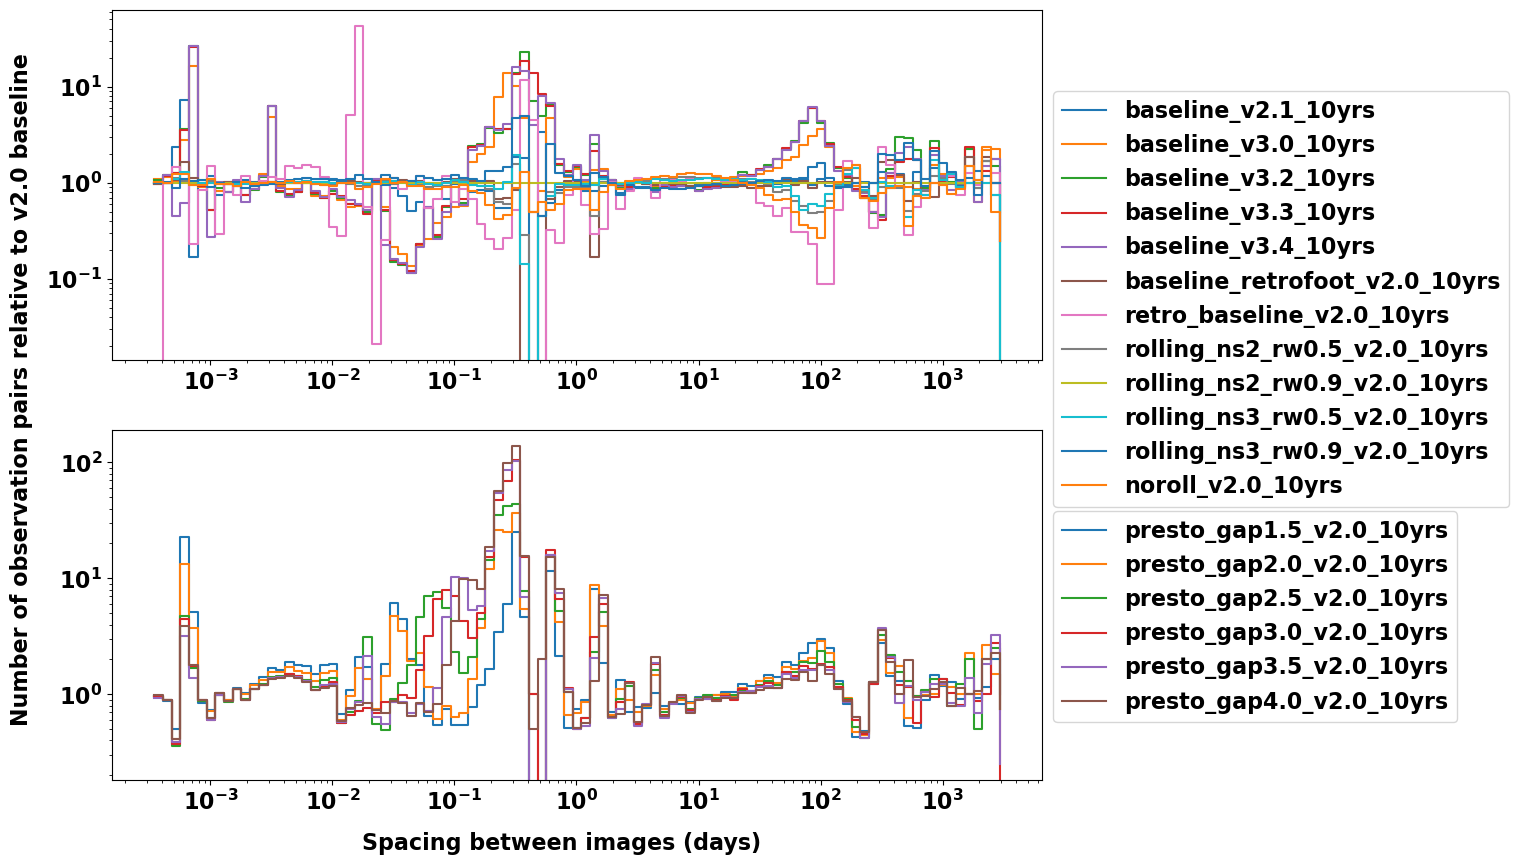

In [14]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10))
fig.text(0.5, 0.04, 'Spacing between images (days)', ha='center')
fig.text(0.04, 0.5, 'Number of observation pairs relative to v2.0 baseline', va='center', rotation='vertical')

for family in ['baseline', 'retro', 'rolling', 'noroll']:
    for run in b[family].keys():
        if run == "baseline_v2.0_10yrs":
            continue
        metric = list(b[family][run].keys())[0]
        x = b[family][run][metric]['dt_hist_x']
        y = b[family][run][metric]['dt_hist_y']/b["baseline"]["baseline_v2.0_10yrs"]["baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
        ax1.semilogy(x,y,ds='steps-post', label=run)
ax1.set_xscale('log')
ax1.legend(bbox_to_anchor=(1, 0.8), loc='upper left', ncol=1)

for family in ['presto']:
    for run in b[family].keys():
        if run == "presto_gap1.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap2.0_mix_v2.0_10yrs":
            continue
        if run == "presto_gap2.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap3.0_mix_v2.0_10yrs":
            continue
        if run == "presto_gap3.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap4.0_mix_v2.0_10yrs":
            continue
        metric = list(b[family][run].keys())[0]
        x = b[family][run][metric]['dt_hist_x']
        y = b[family][run][metric]['dt_hist_y']/b["baseline"]["baseline_v2.0_10yrs"]["baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
        ax2.semilogy(x,y,ds='steps-post', label=run) 
ax2.set_xscale('log')
ax2.legend(bbox_to_anchor=(1, 0.8), loc='upper left', ncol=1)
plt.savefig('v2.1_3.4_tgap_histogram.pdf', bbox_inches = "tight")
#plt.gca().set_yscale('log')

<ipython-input-9-8ecbf80092c7>:18: RuntimeWarning: divide by zero encountered in true_divide
  y = b[family][run][metric]['dt_hist_y']/b["baseline_nexp2_v1.7.1_10yrs"]["baseline_nexp2_v1.7.1_10yrs"]["baseline_nexp2_v1_7_1_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
<ipython-input-9-8ecbf80092c7>:18: RuntimeWarning: divide by zero encountered in true_divide
  y = b[family][run][metric]['dt_hist_y']/b["baseline_nexp2_v1.7.1_10yrs"]["baseline_nexp2_v1.7.1_10yrs"]["baseline_nexp2_v1_7_1_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
<ipython-input-9-8ecbf80092c7>:18: RuntimeWarning: invalid value encountered in true_divide
  y = b[family][run][metric]['dt_hist_y']/b["baseline_nexp2_v1.7.1_10yrs"]["baseline_nexp2_v1.7.1_10yrs"]["baseline_nexp2_v1_7_1_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
<ipython-input-9-8ecbf80092c7>:18: RuntimeWarning: divide by zero encountered in true_divide
  y = b[family][run][metric]['dt_hist_y']/b["baseline_nexp2_v1.7.1_10yrs"]["baseline_n

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


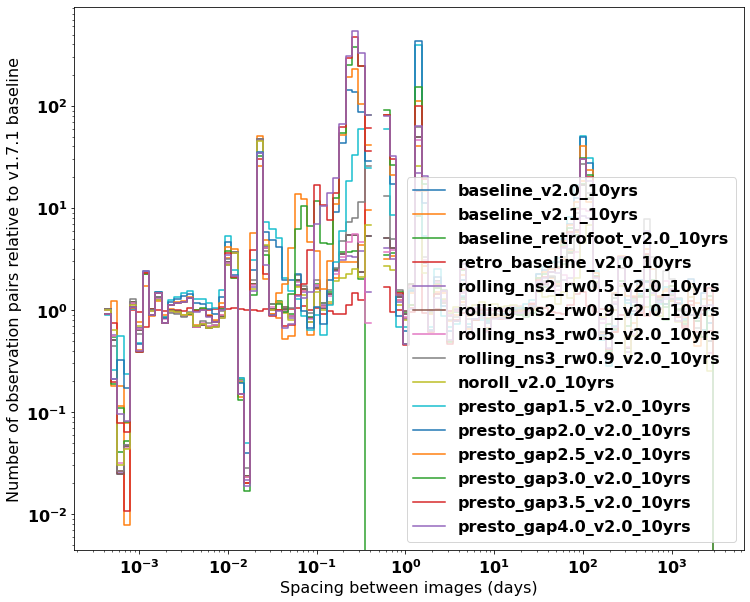

In [9]:
fig = plt.figure(figsize=(12,10))
for family in ['baseline', 'retro', 'rolling', 'noroll', 'presto']:
    for run in b[family].keys():
        if run == "presto_gap1.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap2.0_mix_v2.0_10yrs":
            continue
        if run == "presto_gap2.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap3.0_mix_v2.0_10yrs":
            continue
        if run == "presto_gap3.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap4.0_mix_v2.0_10yrs":
            continue
        metric = list(b[family][run].keys())[0]
        x = b[family][run][metric]['dt_hist_x']
        y = b[family][run][metric]['dt_hist_y']/b["baseline_nexp2_v1.7.1_10yrs"]["baseline_nexp2_v1.7.1_10yrs"]["baseline_nexp2_v1_7_1_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
        plt.semilogy(x,y,ds='steps-post', label=run)
plt.gca().set_xscale('log')
plt.xlabel('Spacing between images (days)')
plt.ylabel('Number of observation pairs relative to v1.7.1 baseline')
plt.legend(loc = 'lower right')
#plt.savefig('v2.1_tgap_histogram.png')
#plt.gca().set_yscale('log')

Text(0.5, 0, 'Spacing between images (days)')

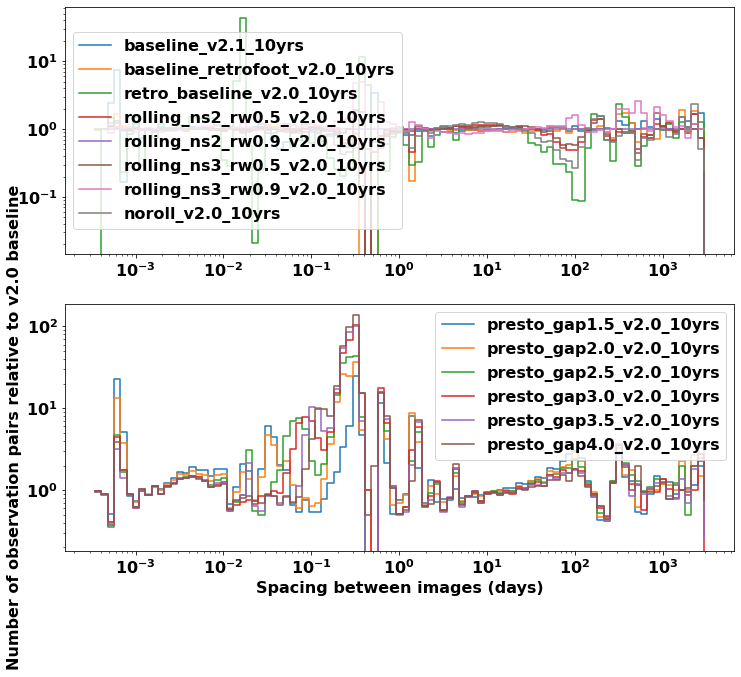

In [12]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10))
plt.ylabel('Number of observation pairs relative to v2.0 baseline', fontweight='bold')


for family in ['baseline', 'retro', 'rolling', 'noroll']:
    for run in b[family].keys():
        if run == "baseline_v2.0_10yrs":
            continue
        metric = list(b[family][run].keys())[0]
        x = b[family][run][metric]['dt_hist_x']
        y = b[family][run][metric]['dt_hist_y']/b["baseline"]["baseline_v2.0_10yrs"]["baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
        ax1.semilogy(x,y,ds='steps-post', label=run)
ax1.set_xscale('log')
#ax1.set_ylabel('Number of observation pairs relative to v2.0 baseline',fontweight='bold')
ax1.legend()

for family in ['presto']:
    for run in b[family].keys():
        if run == "presto_gap1.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap2.0_mix_v2.0_10yrs":
            continue
        if run == "presto_gap2.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap3.0_mix_v2.0_10yrs":
            continue
        if run == "presto_gap3.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap4.0_mix_v2.0_10yrs":
            continue
        metric = list(b[family][run].keys())[0]
        x = b[family][run][metric]['dt_hist_x']
        y = b[family][run][metric]['dt_hist_y']/b["baseline"]["baseline_v2.0_10yrs"]["baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
        ax2.semilogy(x,y,ds='steps-post', label=run) 
ax2.set_xscale('log')
ax2.legend()
plt.xlabel('Spacing between images (days)', fontweight='bold')
#plt.savefig('NEW_v2.1_tgap_histogram.pdf', bbox_inches = "tight")
#plt.gca().set_yscale('log')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


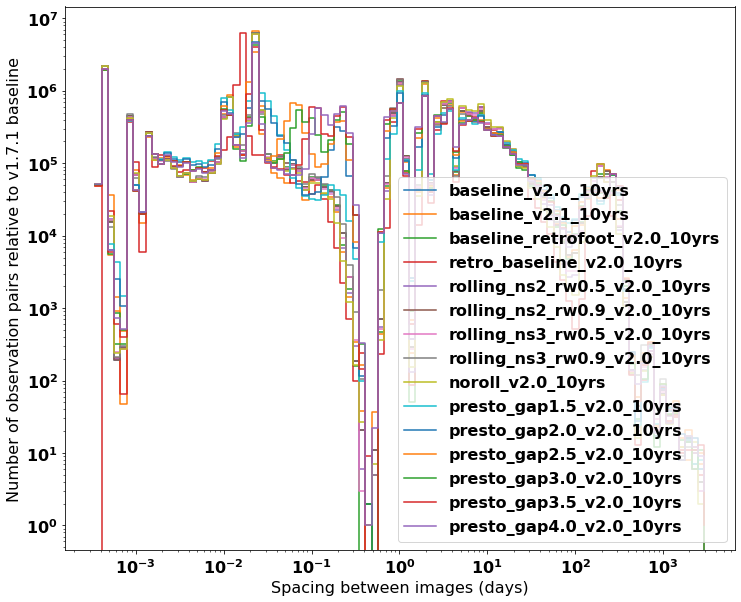

In [6]:
fig = plt.figure(figsize=(12,10))
for family in ['baseline', 'retro', 'rolling', 'noroll', 'presto']:
    for run in b[family].keys():
        if run == "presto_gap1.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap2.0_mix_v2.0_10yrs":
            continue
        if run == "presto_gap2.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap3.0_mix_v2.0_10yrs":
            continue
        if run == "presto_gap3.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap4.0_mix_v2.0_10yrs":
            continue
        metric = list(b[family][run].keys())[0]
        x = b[family][run][metric]['dt_hist_x']
        y = b[family][run][metric]['dt_hist_y']
        plt.semilogy(x,y,ds='steps-post', label=run)
plt.gca().set_xscale('log')
plt.xlabel('Spacing between images (days)')
plt.ylabel('Number of observation pairs relative to v1.7.1 baseline')
plt.legend(loc = 'lower right')
#plt.savefig('v2.1_tgap_histogram.png')
#plt.gca().set_yscale('log')

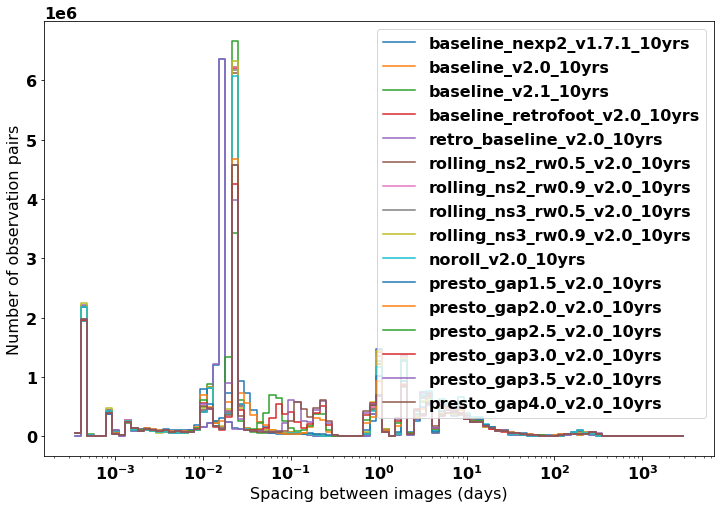

In [8]:
fig = plt.figure(figsize=(12,8))
for family in b.keys():
    for run in b[family].keys():
        #metric = 'baseline_nexp1_v1_7_10yrs_Tgaps_observationStartMJD_HEAL'
        if run == "presto_gap1.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap2.0_mix_v2.0_10yrs":
            continue
        if run == "presto_gap2.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap3.0_mix_v2.0_10yrs":
            continue
        if run == "presto_gap3.5_mix_v2.0_10yrs":
            continue
        if run == "presto_gap4.0_mix_v2.0_10yrs":
            continue
        metric = list(b[family][run].keys())[0]

        x = b[family][run][metric]['dt_hist_x']
        y = b[family][run][metric]['dt_hist_y']
        plt.plot(x,y,ds='steps-post', label=run)
plt.gca().set_xscale('log')
plt.xlabel('Spacing between images (days)')
plt.ylabel('Number of observation pairs')
plt.legend(loc = 'upper right')

### 3 subplots

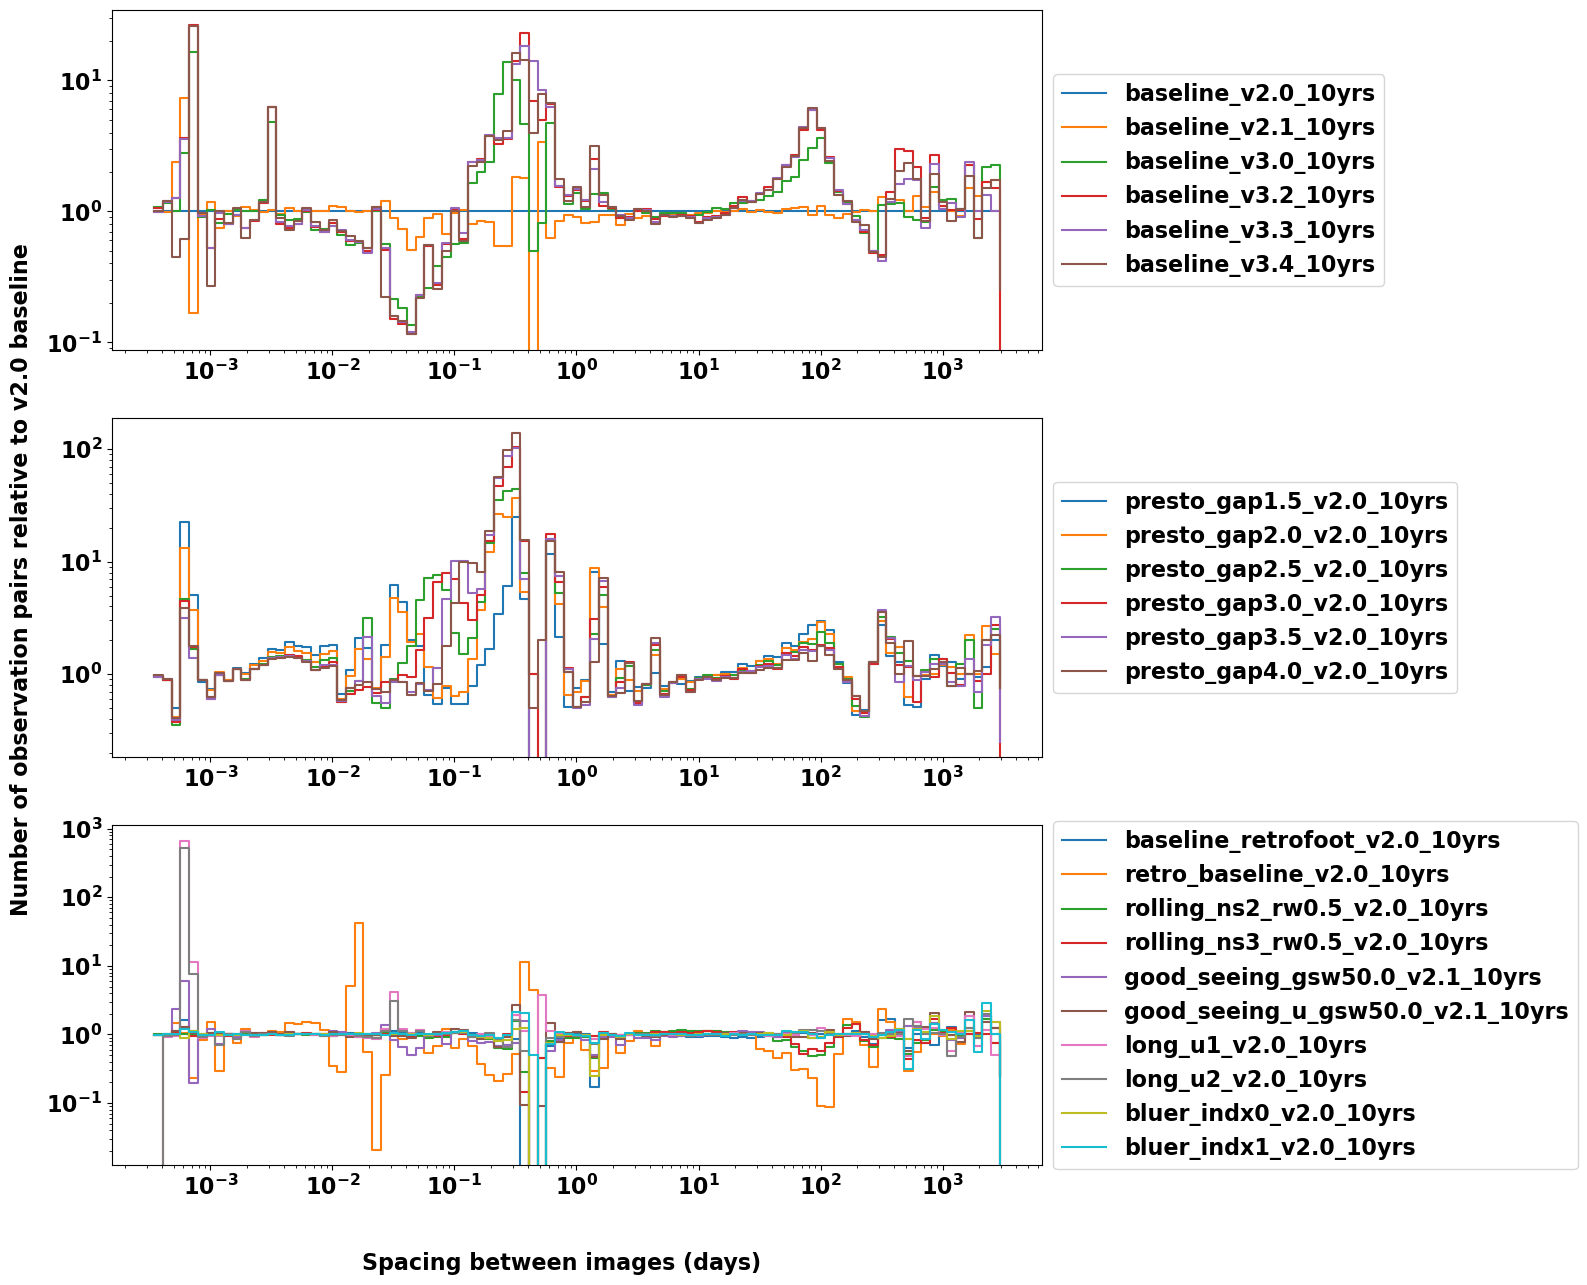

In [11]:
import matplotlib.pyplot as plt

# Part C
import matplotlib
font = {'family': 'sans-serif',
        'weight': 'bold',
        'size': 16}
matplotlib.rc('font', **font)

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 15))
fig.text(0.5, 0.04, 'Spacing between images (days)', ha='center')
fig.text(0.04, 0.5, 'Number of observation pairs relative to v2.0 baseline', va='center', rotation='vertical')

cadences_to_plot = [
    "baseline_v2.0_10yrs",
    "baseline_v2.1_10yrs",
    "baseline_v3.0_10yrs",
    "baseline_v3.2_10yrs",
    "baseline_v3.3_10yrs",
    "baseline_v3.4_10yrs",
    "baseline_retrofoot_v2.0_10yrs",
    "retro_baseline_v2.0_10yrs",
    "rolling_ns2_rw0.5_v2.0_10yrs",
    #"rolling_ns2_rw0.9_v2.0_10yrs",
    "rolling_ns3_rw0.5_v2.0_10yrs",
    #"rolling_ns3_rw0.9_v2.0_10yrs",
    "noroll_v2.0_10yrs.db",
    #"good_seeing_gsw0.0_v2.1_10yrs",
    "good_seeing_gsw50.0_v2.1_10yrs",
    #"good_seeing_u_gsw0.0_v2.1_10yrs",
    "good_seeing_u_gsw50.0_v2.1_10yrs",
    "long_u2_v2.0_10yrs",
    "long_u1_v2.0_10yrs",
    "bluer_indx0_v2.0_10yrs",
    "bluer_indx1_v2.0_10yrs"
]

# Plotting for ax1
for family in ["baseline"]:
    for run in b[family].keys():
        if run in cadences_to_plot:
            metric = list(b[family][run].keys())[0]
            x = b[family][run][metric]['dt_hist_x']
            y = b[family][run][metric]['dt_hist_y'] / b["baseline"]["baseline_v2.0_10yrs"][
                "baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
            ax1.semilogy(x, y, ds='steps-post', label=run)

ax1.set_xscale('log')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

# Plotting for ax2
for family in ['presto']:
    for run in b[family].keys():
        if run.startswith("presto_gap") and run not in ["presto_gap1.5_mix_v2.0_10yrs",
                                                        "presto_gap2.0_mix_v2.0_10yrs",
                                                        "presto_gap2.5_mix_v2.0_10yrs",
                                                        "presto_gap3.0_mix_v2.0_10yrs",
                                                        "presto_gap3.5_mix_v2.0_10yrs",
                                                        "presto_gap4.0_mix_v2.0_10yrs"]:
            metric = list(b[family][run].keys())[0]
            x = b[family][run][metric]['dt_hist_x']
            y = b[family][run][metric]['dt_hist_y'] / b["baseline"]["baseline_v2.0_10yrs"][
                "baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
            ax2.semilogy(x, y, ds='steps-post', label=run)

ax2.set_xscale('log')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

# Plotting for ax3
for family in ["retro", "rolling", "noroll", "good_seeing", "long_u", "bluer"]:
    for run in b[family].keys():
        if run in cadences_to_plot:
            metric = list(b[family][run].keys())[0]
            x = b[family][run][metric]['dt_hist_x']
            y = b[family][run][metric]['dt_hist_y'] / b["baseline"]["baseline_v2.0_10yrs"][
                "baseline_v2_0_10yrs_Tgaps_observationStartMJD_HEAL"]["dt_hist_y"]
            ax3.semilogy(x, y, ds='steps-post', label=run)

ax3.set_xscale('log')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

plt.savefig('3plot_fbs_v3.4_plot_tgap_histogram.pdf', bbox_inches="tight")
plt.show()
